## Importing Depencencies

In [1]:
from tensorflow.keras.layers import (Input, Conv2D, Reshape, Bidirectional, LSTM, 
                                     Dropout, Dense, TimeDistributed, GlobalAveragePooling1D, 
                                     Attention, concatenate, RNN, LSTMCell) # <-- Add RNN and LSTMCell

In [2]:

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import List, Tuple, Dict, Optional
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, Reshape, Bidirectional, LSTM, Dropout, Attention, concatenate, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

try:
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    _HAVE_SKLEARN = True
except Exception:
    _HAVE_SKLEARN = False


CLASS_NAMES = [
    'happy', 'sad', 'surprised', 'satisfied',
    'protected', 'frightened', 'angry', 'unconcerned'
]


FOLDER_TO_CLASS = {
    'Happy': 'happy',
    'Sad': 'sad', 
    'Surprise': 'surprised',  
    'Satisfied': 'satisfied',
    'Protected': 'protected',
    'Frightened': 'frightened',
    'Angry': 'angry',
    'Unconcerned': 'unconcerned'
}

## Data Loading and Preprocessing Functions

In [3]:
def _read_numeric_csv(filepath: str) -> np.ndarray:
    
    df = pd.read_csv(filepath, low_memory=False)
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    if numeric_df.shape[1] == 0:
        numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    numeric_df = numeric_df.dropna(how='all')
    arr = numeric_df.values.astype(float)
    if arr.ndim == 1:
        arr = arr[:, None]
    return arr

def _ensure_shape_and_resample(raw: np.ndarray, time_steps: int, channels: int, features: int) -> np.ndarray:
    """
    Ensure the data has the correct shape by padding or truncating.
    Reshapes the data to (time_steps, channels, features).
    """
    r, c = raw.shape
    if r == time_steps and c == channels * features:
        return raw.reshape((time_steps, channels, features))
    flat = raw.reshape((-1,))
    needed = time_steps * channels * features
    if flat.size >= needed:
        flat = flat[:needed]
    else:
        pad = np.zeros(needed - flat.size, dtype=flat.dtype)
        flat = np.concatenate([flat, pad], axis=0)
    return flat.reshape((time_steps, channels, features))

def _normalize_per_sample(sample: np.ndarray) -> np.ndarray:
    """
    Normalize each sample by subtracting mean and dividing by standard deviation.
    Handles cases with very small standard deviation.
    """
    mean = sample.mean(axis=0, keepdims=True)
    std = sample.std(axis=0, keepdims=True)
    std[std < 1e-8] = 1.0
    return (sample - mean) / std

## Denoising the dataset

In [4]:
import pywt

def _denoise_with_wavelet(raw: np.ndarray, wavelet='db4', level=4) -> np.ndarray:

    denoised_data = np.zeros_like(raw)

    for i in range(raw.shape[1]):
        channel_data = raw[:, i]

        coeffs = pywt.wavedec(channel_data, wavelet, level=level)


        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(channel_data)))

        new_coeffs = [coeffs[0]]
        for c in coeffs[1:]:
            new_coeffs.append(pywt.threshold(c, threshold, mode='soft'))

        denoised_channel = pywt.waverec(new_coeffs, wavelet)

        denoised_data[:, i] = denoised_channel[:raw.shape[0]]

    return denoised_data

## Updated Dataset Loading Function

In [5]:
def load_eeg_dataset(
    data_dir: str,
    time_steps: int = 128,
    channels: int = 55,
    features: int = 64,
    stressed_classes: Optional[List[str]] = None,
    test_size: float = 0.15,
    val_size: float = 0.15,
    random_state: int = 42,
    batch_size: int = 4
) -> Tuple[Dict[str, tf.data.Dataset], Dict]:
    """
    Load EEG dataset from structured folders with class subdirectories.
    Returns datasets and metadata including class weights.
    """
    if stressed_classes is None:
        stressed_classes = ['frightened', 'angry']

    # Find all CSV files in class subdirectories (excluding Baseline)
    files, labels = [], []
    for folder_name, class_name in FOLDER_TO_CLASS.items():
        cls_folder = os.path.join(data_dir, folder_name)
        found = glob.glob(os.path.join(cls_folder, "*.csv"))
        for f in found:
            files.append(f)
            labels.append(class_name)

    if len(files) == 0:
        raise ValueError("No CSV files found. Make sure your directory contains class folders with CSVs.")

    # Process each file
    X_list, y_multi_idx, y_binary = [], [], []
    for fpath, cls in zip(files, labels):
        raw = _read_numeric_csv(fpath)

        # =========================================================
        # NEW STEP: Apply wavelet denoising after reading the data
        raw = _denoise_with_wavelet(raw)
        # =========================================================

        sample = _ensure_shape_and_resample(raw, time_steps, channels, features)
        sample = _normalize_per_sample(sample)
        X_list.append(sample.astype(np.float32))
        idx = CLASS_NAMES.index(cls)
        y_multi_idx.append(idx)
        y_binary.append(1 if cls in stressed_classes else 0)

    # Convert to arrays
    X = np.stack(X_list, axis=0)
    y_multi_idx = np.array(y_multi_idx, dtype=np.int32)
    y_binary = np.array(y_binary, dtype=np.float32)
    y_multi_onehot = tf.keras.utils.to_categorical(y_multi_idx, num_classes=len(CLASS_NAMES)).astype(np.float32)

    # ... (the rest of the function remains exactly the same) ...

    # Calculate class weights for imbalanced datasets
    class_weights = None
    if _HAVE_SKLEARN:
        weights = compute_class_weight('balanced', classes=np.arange(len(CLASS_NAMES)), y=y_multi_idx)
        class_weights = {i: float(w) for i, w in enumerate(weights)}

    # Split data into train, validation, and test sets
    if _HAVE_SKLEARN:
        test_val = test_size + val_size
        train_idx, temp_idx, _, y_temp = train_test_split(
            np.arange(len(X)), y_multi_idx, test_size=test_val,
            random_state=random_state, stratify=y_multi_idx
        )
        if val_size > 0:
            val_idx, test_idx, _, _ = train_test_split(
                temp_idx, y_temp, test_size=(test_size / test_val),
                random_state=random_state, stratify=y_temp
            )
        else:
            val_idx, test_idx = [], temp_idx
    else:
        N = len(X)
        idxs = np.arange(N)
        np.random.seed(random_state)
        np.random.shuffle(idxs)
        n_test = int(N * test_size)
        n_val = int(N * val_size)
        test_idx = idxs[:n_test]
        val_idx = idxs[n_test:n_test+n_val]
        train_idx = idxs[n_test+n_val:]

    # Create TensorFlow datasets
    def make_ds(indices, weights_dict):
        x = X[indices]
        y_dict = {
            'stressed_not_stressed_output': y_binary[indices],
            'emotion_class_output': y_multi_onehot[indices]
        }
        emotion_labels = y_multi_idx[indices]
        sample_weights_emotion = np.array([weights_dict[label] for label in emotion_labels])
        sample_weights_stress = np.ones_like(y_binary[indices])
        sample_weights = {
            'stressed_not_stressed_output': sample_weights_stress,
            'emotion_class_output': sample_weights_emotion
        }
        ds = tf.data.Dataset.from_tensor_slices((x, y_dict, sample_weights))
        ds = ds.shuffle(buffer_size=len(indices), seed=random_state).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    datasets = {
        'train': make_ds(train_idx, class_weights),
        'val': make_ds(val_idx, class_weights) if len(val_idx) > 0 else None,
        'test': make_ds(test_idx, class_weights) if len(test_idx) > 0 else None
    }

    class_counts = {cls: 0 for cls in CLASS_NAMES}
    for cls in labels:
        class_counts[cls] += 1

    meta = {
        'class_to_index': {c: i for i, c in enumerate(CLASS_NAMES)},
        'index_to_class': {i: c for i, c in enumerate(CLASS_NAMES)},
        'counts': class_counts,
        'total_samples': len(X),
        'class_weights': class_weights
    }

    return datasets, meta

## Model Definition

In [6]:
def create_eeg_model(input_shape):
    """
    Create a 'lighter' and stable multi-output model to consume less memory.
    It includes the 'hard_sigmoid' fix to prevent CudnnRNN errors.
    """
    input_layer = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z, axis=-1))(input_layer)

    # Reduced filters in Conv2D layers
    x = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'))(x)

    x = Reshape((input_shape[0], -1))(x)

    # Reduced units in LSTM layers and the required 'hard_sigmoid' fix
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(16, return_sequences=True))(x)
    x = Dropout(0.25)(x)

    # Attention and Output layers
    attention_output = Attention()([x, x])
    x = concatenate([x, attention_output], axis=-1)
    x = GlobalAveragePooling1D()(x)

    binary_head = Dense(32, activation='relu')(x)
    binary_head = Dropout(0.25)(binary_head)
    binary_head_output = Dense(1, activation='sigmoid', name='stressed_not_stressed_output')(binary_head)

    multiclass_head = Dense(32, activation='relu')(x)
    multiclass_head = Dropout(0.25)(multiclass_head)
    multiclass_head_output = Dense(len(CLASS_NAMES), activation='softmax', name='emotion_class_output')(multiclass_head)

    model = Model(inputs=input_layer, outputs=[binary_head_output, multiclass_head_output])
    return model


## Model Instantiation and Compilation

In [7]:
# Define input shape parameters
INPUT_TIME_STEPS = 128
INPUT_CHANNELS = 55
INPUT_FEATURES = 64
INPUT_3D_SHAPE = (INPUT_TIME_STEPS, INPUT_CHANNELS, INPUT_FEATURES)

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001, amsgrad=True)  # <-- Add amssgrad=True)

# Create the model
model = create_eeg_model(INPUT_3D_SHAPE)

# Compile the model with appropriate loss functions and metrics for each output
model.compile(optimizer=optimizer, run_eagerly=True,
              loss={'stressed_not_stressed_output': 'binary_crossentropy',
                    'emotion_class_output': 'categorical_crossentropy'},
              metrics={'stressed_not_stressed_output': ['accuracy'],
                       'emotion_class_output': ['accuracy']},
              weighted_metrics=[]) # <-- Add this line
# Display model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 55, 64  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 55, 64,  0           ['input_1[0][0]']                
                                 1)                                                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 128, 55, 64,  320        ['lambda[0][0]']                 
 ted)                            32)                                                          

## Example Usage

In [8]:
# Example of how to use the functions with your dataset
# Note: Replace with your actual dataset path
dataset_path = "D:/Github/EEG-Emotion-Detection/dataset"

# Load the dataset
datasets, meta = load_eeg_dataset(dataset_path)

# Print dataset information
print(f"Total samples: {meta['total_samples']}")
print("Samples per class:")
for cls, count in meta['counts'].items():
    print(f"  {cls}: {count}")

print("\nClass weights:")
for idx, weight in meta['class_weights'].items():
    print(f"  {meta['index_to_class'][idx]}: {weight:.2f}")

# The returned datasets dictionary contains:
# - datasets['train']: Training dataset
# - datasets['val']: Validation dataset (if val_size > 0)
# - datasets['test']: Test dataset

# Example training (uncomment when ready to train):
# history = model.fit(
#     datasets['train'],
#     validation_data=datasets['val'],
#     epochs=50,
#     class_weight={'emotion_class_output': meta['class_weights']}
# )

C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invali

Total samples: 238
Samples per class:
  happy: 30
  sad: 30
  surprised: 30
  satisfied: 29
  protected: 30
  frightened: 30
  angry: 30
  unconcerned: 29

Class weights:
  happy: 0.99
  sad: 0.99
  surprised: 0.99
  satisfied: 1.03
  protected: 0.99
  frightened: 0.99
  angry: 0.99
  unconcerned: 1.03


## Additional Utility Function for Data Exploration

In [9]:
def explore_dataset(data_dir):
    """
    Explore the dataset structure and count files in each class folder.
    """
    print("Dataset structure exploration:")
    print("=" * 50)
    
    total_files = 0
    for folder_name, class_name in FOLDER_TO_CLASS.items():
        cls_folder = os.path.join(data_dir, folder_name)
        found = glob.glob(os.path.join(cls_folder, "*.csv"))
        print(f"{folder_name} ({class_name}): {len(found)} files")
        total_files += len(found)
    
    print("=" * 50)
    print(f"Total files (excluding Baseline): {total_files}")
    
    # Check Baseline folder separately
    baseline_folder = os.path.join(data_dir, "Baseline")
    baseline_files = glob.glob(os.path.join(baseline_folder, "*.csv"))
    print(f"Baseline files (excluded): {len(baseline_files)}")
    
    return total_files

# Explore your dataset
total_files = explore_dataset(dataset_path)

Dataset structure exploration:
Happy (happy): 30 files
Sad (sad): 30 files
Surprise (surprised): 30 files
Satisfied (satisfied): 29 files
Protected (protected): 30 files
Frightened (frightened): 30 files
Angry (angry): 30 files
Unconcerned (unconcerned): 29 files
Total files (excluding Baseline): 238
Baseline files (excluded): 29


## Define Callbacks for Training

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

# Create a timestamp for model versioning
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define callbacks
callbacks = [
    # Save the best model during training
    ModelCheckpoint(
        filepath=f'models/best_model_{timestamp}.h5',
        monitor='val_emotion_class_output_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Stop training if no improvement after 15 epochs
    EarlyStopping(
        monitor='val_emotion_class_output_accuracy',
        patience=100,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation accuracy plateaus
    ReduceLROnPlateau(
        monitor='val_emotion_class_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Log training progress for TensorBoard
    TensorBoard(
        log_dir=f'logs/fit/{timestamp}',
        histogram_freq=1
    )
]

## Train the Model

In [11]:
# NEW CODE
history = model.fit(
    datasets['train'],
    epochs=100,
    validation_data=datasets['val'],
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: nan - stressed_not_stressed_output_loss: nan - emotion_class_output_loss: nan - stressed_not_stressed_output_accuracy: 0.7229 - emotion_class_output_accuracy: 0.1205
Epoch 1: val_emotion_class_output_accuracy improved from -inf to 0.13889, saving model to models\best_model_20250921-055206.h5
42/42 [==============================] - 12s 157ms/step - loss: nan - stressed_not_stressed_output_loss: nan - emotion_class_output_loss: nan - stressed_not_stressed_output_accuracy: 0.7229 - emotion_class_output_accuracy: 0.1205 - val_loss: nan - val_stressed_not_stressed_output_loss: nan - val_emotion_class_output_loss: nan - val_stressed_not_stressed_output_accuracy: 0.7500 - val_emotion_class_output_accuracy: 0.1389 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: nan - stressed_not_stressed_output_loss: nan - emotion_class_output_loss: nan - stressed_not_stressed_output_accuracy: 0.7470 - 

## Evaluate the Model

In [12]:
# Evaluate on test set
if datasets['test'] is not None:
    test_results = model.evaluate(datasets['test'], verbose=1)
    print("\nTest Results:")
    print(f"Stress Detection Loss: {test_results[1]:.4f}")
    print(f"Stress Detection Accuracy: {test_results[3]:.4f}")
    print(f"Emotion Classification Loss: {test_results[2]:.4f}")
    print(f"Emotion Classification Accuracy: {test_results[4]:.4f}")

9/9 [==============================] - 1s 57ms/step - loss: nan - stressed_not_stressed_output_loss: nan - emotion_class_output_loss: nan - stressed_not_stressed_output_accuracy: 0.7500 - emotion_class_output_accuracy: 0.1111

Test Results:
Stress Detection Loss: nan
Stress Detection Accuracy: 0.7500
Emotion Classification Loss: nan
Emotion Classification Accuracy: 0.1111


## Plot Training History

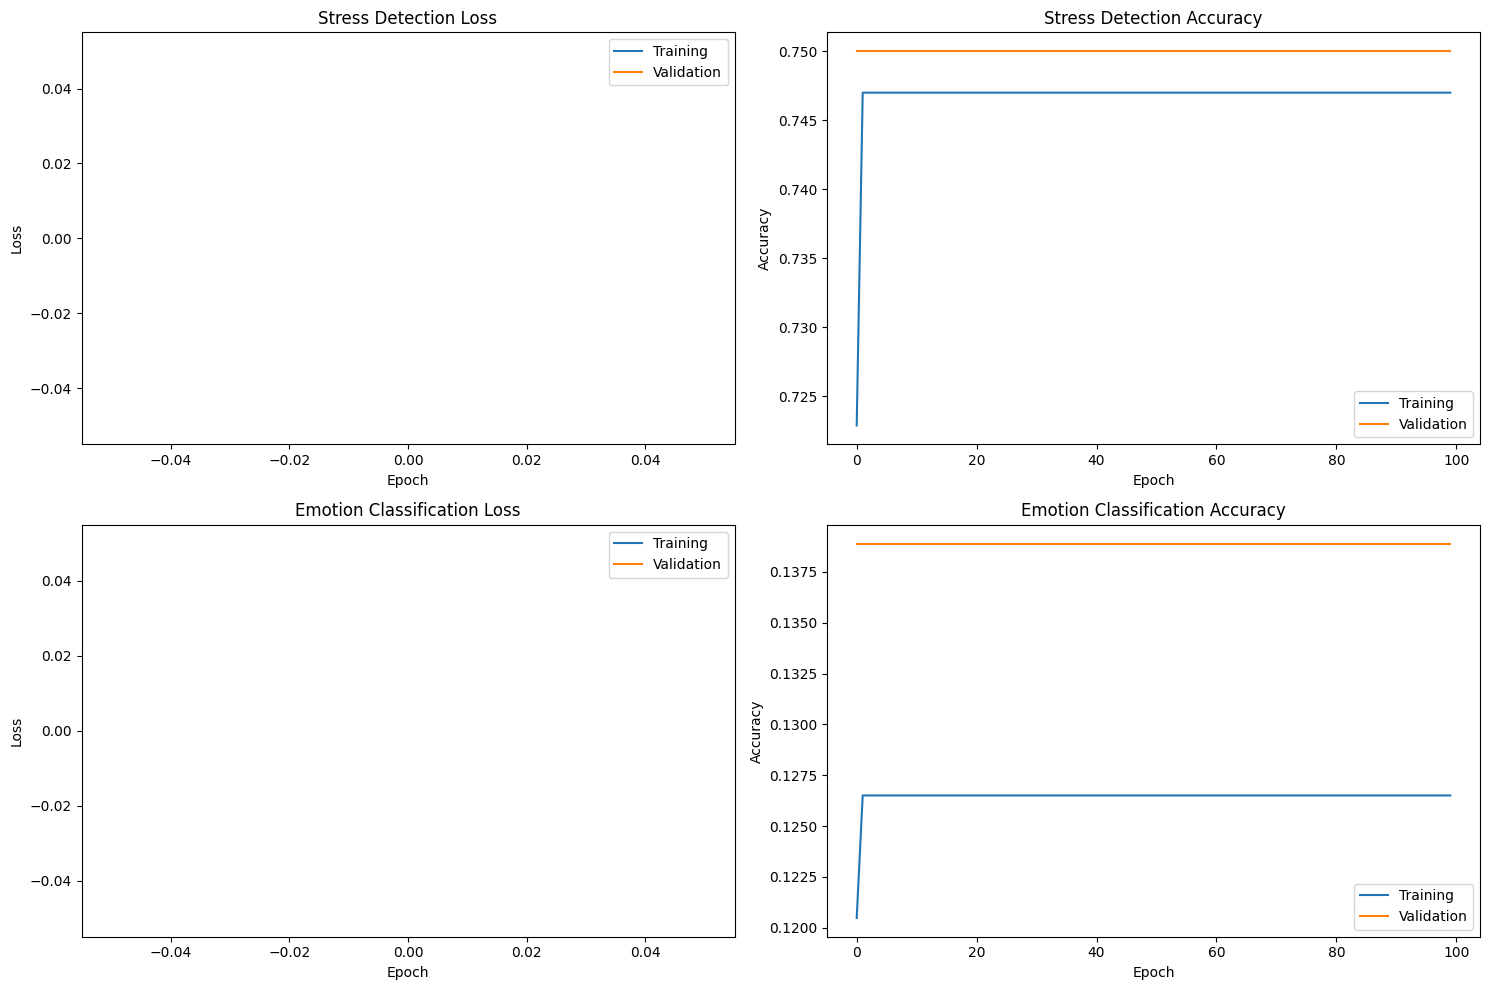

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Stress detection loss
    axes[0, 0].plot(history.history['stressed_not_stressed_output_loss'], label='Training')
    axes[0, 0].plot(history.history['val_stressed_not_stressed_output_loss'], label='Validation')
    axes[0, 0].set_title('Stress Detection Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Stress detection accuracy
    axes[0, 1].plot(history.history['stressed_not_stressed_output_accuracy'], label='Training')
    axes[0, 1].plot(history.history['val_stressed_not_stressed_output_accuracy'], label='Validation')
    axes[0, 1].set_title('Stress Detection Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Emotion classification loss
    axes[1, 0].plot(history.history['emotion_class_output_loss'], label='Training')
    axes[1, 0].plot(history.history['val_emotion_class_output_loss'], label='Validation')
    axes[1, 0].set_title('Emotion Classification Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    
    # Emotion classification accuracy
    axes[1, 1].plot(history.history['emotion_class_output_accuracy'], label='Training')
    axes[1, 1].plot(history.history['val_emotion_class_output_accuracy'], label='Validation')
    axes[1, 1].set_title('Emotion Classification Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

## Make Predictions and Analyze Results

9/9 [==============================] - 0s 41ms/step
Stress Detection Report:
              precision    recall  f1-score   support

Not Stressed       0.75      1.00      0.86        27
    Stressed       0.00      0.00      0.00         9

    accuracy                           0.75        36
   macro avg       0.38      0.50      0.43        36
weighted avg       0.56      0.75      0.64        36


Emotion Classification Report:
              precision    recall  f1-score   support

       happy       0.11      1.00      0.20         4
         sad       0.00      0.00      0.00         4
   surprised       0.00      0.00      0.00         5
   satisfied       0.00      0.00      0.00         5
   protected       0.00      0.00      0.00         5
  frightened       0.00      0.00      0.00         4
       angry       0.00      0.00      0.00         5
 unconcerned       0.00      0.00      0.00         4

    accuracy                           0.11        36
   macro avg       0.0

C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\dasko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

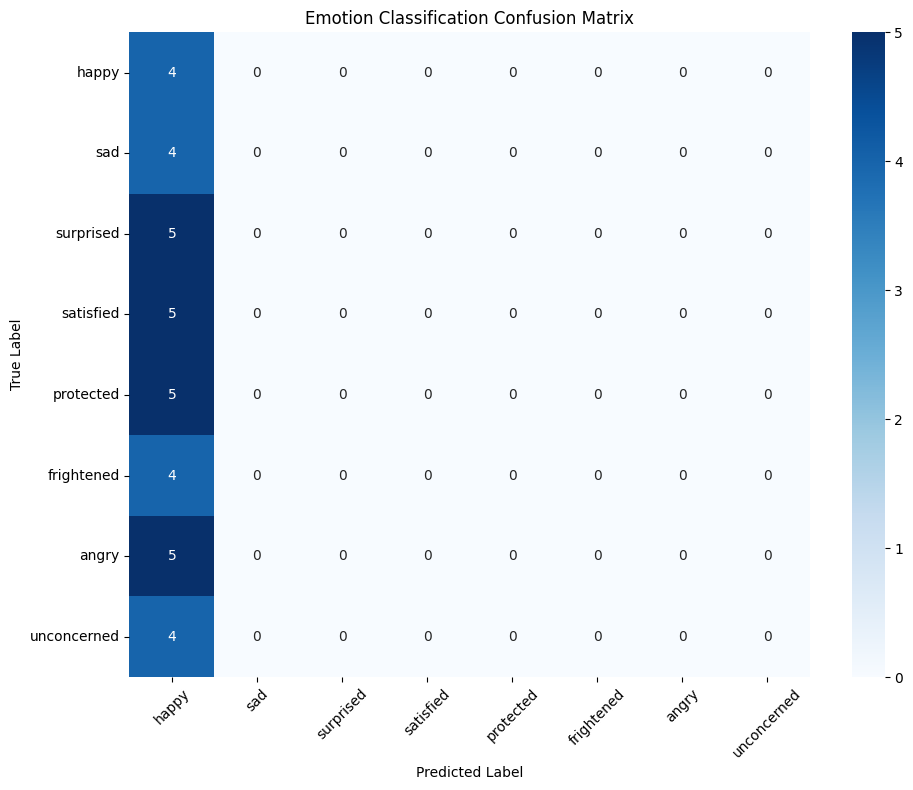

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def analyze_predictions(model, dataset):
    """
    Generates and displays classification reports and a confusion matrix.
    This version correctly handles datasets that yield (features, labels, weights).
    """
    # Get predictions for the entire dataset at once
    predictions = model.predict(dataset)
    
    # --- THIS IS THE CORRECTED PART ---
    # Get true labels by iterating through the batched dataset
    y_true_stress = []
    y_true_emotion = []
    # The loop now correctly unpacks three items: features, labels, and weights.
    # We ignore the features (x) and weights (_) since they are not needed here.
    for _, y, _ in dataset:
        y_true_stress.extend(y['stressed_not_stressed_output'].numpy())
        y_true_emotion.extend(np.argmax(y['emotion_class_output'].numpy(), axis=1))
    
    y_true_stress = np.array(y_true_stress)
    y_true_emotion = np.array(y_true_emotion)
    
    # Process predictions
    y_pred_stress = (predictions[0] > 0.5).astype(int).flatten()
    y_pred_emotion = np.argmax(predictions[1], axis=1)
    
    # --- The rest of the function remains the same ---
    # Print classification reports
    print("Stress Detection Report:")
    print(classification_report(y_true_stress, y_pred_stress, 
                                target_names=['Not Stressed', 'Stressed']))
    
    print("\nEmotion Classification Report:")
    print(classification_report(y_true_emotion, y_pred_emotion, 
                                target_names=CLASS_NAMES))
    
    # Plot confusion matrix for emotions
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_emotion, y_pred_emotion)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Emotion Classification Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return y_true_stress, y_pred_stress, y_true_emotion, y_pred_emotion

# Now, when you call this function, it will work correctly
if datasets['test'] is not None:
    y_true_stress, y_pred_stress, y_true_emotion, y_pred_emotion = analyze_predictions(model, datasets['test'])

## Save the Final Model

In [15]:
# Save the final trained model
model.save(f'models/final_model_{timestamp}.h5')
print(f"Model saved as models/final_model_{timestamp}.h5")

# Save the metadata for later use
import json
with open(f'models/model_metadata_{timestamp}.json', 'w') as f:
    json.dump(meta, f)
print(f"Metadata saved as models/model_metadata_{timestamp}.json")

Model saved as models/final_model_20250921-055206.h5
Metadata saved as models/model_metadata_20250921-055206.json
